# Summarization - Full task 'keep it simple'

Scientific papers summarization task divided into 4 steps:

**Step 0 - Download and parse the data** \
**Step 1 - Cited text spans identification** \
**Step 2 - Prepare data for train and inference** \
**Step 3 - Summarize with Pre-Trained Pegasus (no fine-tuning)** \
**Step 4 - Fine-Tune Pre-Trained Pegasus**



In [1]:
#Download the dataset
import requests
import io
import zipfile
import pandas as pd
import numpy as np
import os
# For visualizations
import matplotlib.pyplot as plt
# For regular expressions
import re
# For handling string
import string
# For performing mathematical operations
import math
# Importing spacy
import spacy
# Importing json to read input
import json
# Importing rouge for evaluation
from rouge_score import rouge_scorer

import xml.etree.ElementTree as ET
import seaborn as sns
import matplotlib.pyplot as plt
import html
from collections import defaultdict, Counter

import statistics as stats
import time

from scipy import spatial
from sent2vec.vectorizer import Vectorizer

# for turn text into sentences
import nltk.data
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer 
from collections import Counter
from nltk.corpus import stopwords
import html
from lxml import etree
import unidecode

from scipy import stats as s


nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')


import nltk 
import glob, os
import re
import string
import sys
import random
import xml.etree.ElementTree as ET
import xml.etree




sns.set_style("dark")
plot_dims = (16, 16)




# url = "https://cs.stanford.edu/~myasu/projects/scisumm_net/scisummnet_release1.1__20190413.zip"
# response = requests.get(url)
# with zipfile.ZipFile(io.BytesIO(response.content)) as zipObj:
#     # Extract all the contents of zip file in different directory
#     zipObj.extractall("nlp_data")
#     print("File is unzipped in nlp_data folder") 



/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/priscillaburity/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/priscillaburity/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/priscillaburity/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/priscillaburity/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# import pip
# from pip._internal import main as pipmain

# pipmain(['install', 'datasets'])


## Step 0 - Download and parse the data

In [3]:
# Define data directory
DATA_DIR = "data/nlp_data/scisummnet_release1.1__20190413/top1000_complete"

In [4]:
#get all raw text, break all papers into two parts -- Abstract and rest of document
#first get all filepaths
xmlfiles = []
citations = []
golden_summaries = []
for subdir, dirs, files in os.walk(DATA_DIR):
    for filename in files:
        filepath = subdir + os.sep + filename
        if filepath.endswith(".xml"):
            xmlfiles.append(filepath)
        if filepath.endswith(".json"):
            citations.append(filepath)
        if filepath.endswith(".txt"):
            golden_summaries.append(filepath)    
        

In [5]:
#next parse all XML documents

def parse_xml_abstract(fp):
    """ parse an XML journal article into an abstract and the rest of the text
    """
    try:
        tree = ET.parse(fp)
    except Exception as e:
        return "","",str(e)
    root = tree.getroot()
    
    ab = []
    bod = []
    
    for child in root:
        if child.tag == "ABSTRACT":
            for block in child:
                ab.append(block.text)
        else:
            for block in child:
                bod.append(block.text)
                
    #convert from list --> string
    abstract = "\n".join(ab)
    body = "\n".join(bod)
    
    #decode html entities
    abstract = html.unescape(abstract)
    body = html.unescape(body)
    
    return abstract,body,""




In [6]:
#create DF with papers and citations

raw_cols = []
golden = []
for fpn in range(len(xmlfiles)):
    ab,bod,err = parse_xml_abstract(xmlfiles[fpn])
    if err:
        #print(fp, err)
        continue
    f = open(citations[fpn]) 

    # returns JSON object as  
    # a dictionary 
    data = json.load(f) 
    only_text = []
    for entry in data:
        only_text.append(entry['clean_text'])
#     print(only_text)
    
    f2 = open(golden_summaries[fpn],"r+") 
    golden = f2.read()

    
    raw_cols.append([ab,bod,only_text, golden])

df = pd.DataFrame(raw_cols, columns=["abstract","body","citations", "golden"])
df

,abstract,body,citations,golden
0,We present a method for extracting parts of ob...,We present a method of extracting parts of obj...,[Berland and Charniak (1999) use Hearst style ...,Finding Parts In Very Large Corpora\nWe presen...
1,We describe a series of five statistical model...,We describe a series of five statistical model...,[The program takes the output of char_align (C...,The Mathematics Of Statistical Machine Transla...
2,Previous work has shown that Chinese word segm...,Word segmentation is considered an important f...,[Chinese word segmentation is done by the Stan...,Optimizing Chinese Word Segmentation for Machi...
3,We examine the viability of building large pol...,Polarity lexicons are large lists of phrases t...,[Recent work in this area includes Velikovich ...,The viability of web-derived polarity lexicons...
4,Extracting semantic relationships between enti...,Extraction of semantic relationships between e...,[They use two kinds of features: syntactic one...,Combining Lexical Syntactic And Semantic Featu...
...,...,...,...,...
1004,"In statistical machine translation, correspond...","In statistical machine translation, correspond...","[In addition, Niessen and Ney (2004) decompose...",Statistical Machine Translation With Scarce Re...
1005,We have developed a new program called alignin...,Aligning parallel texts has recently received ...,[There have been quite a number of recent pape...,Robust Bilingual Word Alignment For Machine Ai...
1006,We present an approach to pronoun resolution b...,Pronoun resolution is a difficult but vital pa...,"[, We follow the closed track setting where sy...",Bootstrapping Path-Based Pronoun Resolution\nW...
1007,We use logical inference techniques for recogn...,Recognising textual entailment (RTE) is the ta...,"[However, this method does not work for realwo...",Recognising Textual Entailment With Logical In...


## Step 1 - Cited text spans identification

Finding the top x sentences in the body that have the largest similarity (as per ROUGE score) with the citations 

### Step 1.1 - Define helper functions

In [7]:
# NOT BEING USED

from dateutil.parser import parse

def is_date(string, fuzzy=False):
    """
    Return whether the string can be interpreted as a date.

    :param string: str, string to check for date
    :param fuzzy: bool, ignore unknown tokens in string if True
    """
    try: 
        parse(string, fuzzy=fuzzy)
        return True

    except ValueError:
        return False

In [8]:
def checkQuality(sentence):
    
    '''Check the quality of body sentences, to classify each of them as eligible (or not) to be a cited text span'''
    
    lemmatizer = WordNetLemmatizer() 
    
    tokenized_text = nltk.word_tokenize(sentence)
    length = len(tokenized_text)
    alpha = 0
    nonAlpha = 0
    found = 0
    nonFound = 0
    upper = 0
    stop = 0
    stop_words = set(stopwords.words('english')) 
    
    for token in tokenized_text:
        #print(token)
        if len(token)==1:
            if token.isalpha():
                # count number of single alpha chars
                alpha+=1
            else:
                # count number of not single non-alpha chars
                nonAlpha+=1
        else:
            if(token.lower() in stop_words):
                # count number of stop words
                stop+=1
            else:
                lemma = lemmatizer.lemmatize(token.lower())
                # count number of Synsets for alpha tokens
                if token.isalpha():
                    if (len(wn.synsets(lemma))>0):
                        found+=1 # alpha tokens that have Synsets
                    else:
                        nonFound+=1 # alpha tokens that dont have Synsets
                else:
                    nonAlpha+=1 #non alpha tokens
    
    # calculate shares 
    alphaS = alpha/length
    nonAlphaS = nonAlpha/length
    foundS = found/length
    nonFoundS = nonFound/length
#     upperS = upper/length
    stopS = stop/length
    
    good_quality = True
    
    if(nonFoundS>0.2):
        good_quality = False
    if(foundS<0.1):
        good_quality = False
    if(alphaS>0.2):
        good_quality = False
    if(nonAlphaS>0.5):
        good_quality = False
    if len(tokenized_text)< 6:
        good_quality = False
    
    if ("equation" in sentence.lower()) | ("section" in sentence.lower()) | ("table" in sentence.lower()) | ("figure" in sentence.lower()) | ("=" in sentence) | (">" in sentence) | ("<" in sentence) | ("p(" in sentence.lower()):
        good_quality = False
    
    # remove sentences that has dates
    match = re.match(r'.*([1-3][0-9]{3})', sentence)
    if match is not None:
        good_quality = False 
        
    return good_quality



In [9]:
def cited_text_spans_ids(df,n_sent = 3):

    '''Find (n_sent) body sentences most similar to citation sentences 
    inputs: 
        df: dataframe with simularity scores between each body sentence and citation 
        n_set: number of body sentences to output
    output:
        list of best ranked body sentetences ids
    
    ''' 
    
    # empty list where we'll store best scored body sentences 
    body_sent_all_ids = []
    body_sent_id = []
     
    # create an empty dataframe (num rows = num sentences in citations;  num col = n_sent)
    # we'll store here the body sentences ids with largest similarity
    sim_df_max = pd.DataFrame(0.0, index=[j for j in range(len(citations_sentences))], columns= [j for j in range(n_sent)])
    
    for ns in range(n_sent):
        # get the indexes that maximize similarity for each column (i.e., for each citation sentence)    
        sim_df_max[ns] = sim_df.idxmax(axis=0, skipna=True)
        # reset the largest values to zero, so we can retreive other top values in the loop
        sim_df[ns][sim_df_max[ns]] = 0

    
    # loop over the number of body sentences we want to retrieve
    for ns in range(n_sent): 
        # turn all columns into a list of best scored body sentences ids  
        li = sim_df_max[ns].tolist() 
        body_sent_all_ids = body_sent_all_ids + li
    
#     print(body_sent_all_ids)
    for ns in range(n_sent):   
        # append best scored sentence id over all citations sentences
        best_sent_id_single = int(s.mode(body_sent_all_ids)[0])
        body_sent_id.append(best_sent_id_single)
        # reset the largest values to zero, so we can retreive other top values in the loop                    
        body_sent_all_ids = list(filter(lambda a: a != best_sent_id_single, body_sent_all_ids)) 
#         print(body_sent_all_ids)
#         if len(body_sent_all_ids) == 0:
#             break

    return body_sent_id



### Step 1.2 - Select 'x' body sentences to "represent" citations as model inputs - i.e., find cited text spans

In [10]:
## create an empty column in the original dataframe, in which we'll store the cited text spans for each paper 
df['cited_text_spans'] = ""

## instantiate nlp tools to read the data
# vectorizer = Vectorizer() - NOT BEING USED - USED FOR COSINE SIMILARITY
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
lemmatizer = WordNetLemmatizer() 

## instantiate rouge score
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# start time to keep track of the timing
start = time.time()

In [ ]:
for paper_id in df.index: # [i for i in df.index if i >79]:
    
    body_sentences = []
    
    # split body into sentences
    body_sentences_tok = df.body[paper_id].replace("et al.", "et al").replace("e.g.", "eg").replace("eg.", "eg").replace("i.e.", "ie").replace("ie.", "ie")
    body_sentences_tok = body_sentences_tok.replace(".1", ". ").replace(".2", ". ").replace(".3", ".").replace(".4", ". ").replace(".5", ". ").replace(".6", ". ").replace(".7", ". ").replace(".8", ". ").replace(".9", ". ")

    # tokenize body sentences
    body_sentences_tok = tokenizer.tokenize(body_sentences_tok)
        
    # truncate too large body sentences (larger than 512 throws an error - rare cases) and remove "?"
    body_sentences_tok = [s.replace("?", "") for s in body_sentences_tok if len(s) <= 512]
    
    # remove papers that are too small even before quality check
    if len(body_sentences_tok) < 10:
        continue
        
    # get citations sentences (discarding empty entries)
    citations_sentences = list(filter(None, df.citations[paper_id]))
    
    # clean citations
    for c in range(len(citations_sentences)):
        citations_sentences[c] = re.sub(r"\s\([A-Z][a-z]+,\s[A-Z][a-z]?\.[^\)]*,\s\d{4}\)", "", citations_sentences[c])
    
#     print(paper_id, "size after quality check:", len(body_sentences_tok))
    
    # truncate the center of the body for large bodies
    if len(body_sentences_tok) > 300:
        body_sentences_tok = body_sentences_tok[:150] + body_sentences_tok[-150:]
#         print("truncated", paper_id, "new size:", len(body_sentences_tok))
        
    # find body sentences with quality
    for i in range(len(body_sentences_tok)):
        if len(body_sentences_tok[i])>0:
            if checkQuality(body_sentences_tok[i]):
                body_sentences.append(body_sentences_tok[i])
                
#     print("step 1 done")

    # create an empty dataframe (num rows = num sentences in body;  num col = num sentences in citations)
    sim_df = pd.DataFrame(0.0, index=[j for j in range(len(body_sentences))], columns=[j for j in range(len(citations_sentences))])

# #     # vectorize body sentences
# #     vectorizer.bert(body_sentences)
# #     vectors_bert_body = vectorizer.vectors

# #     # vectorize citations sentences
# #     vectorizer.bert(citations_sentences)
# #     vectors_bert_citations = vectorizer.vectors

#     print("step 2 done")

    # nested loop: over body sentences and citations sentences
    for body_sentence_id in range(len(body_sentences)):
        for citation_sentence_id in range(len(citations_sentences)):
            # fill empty dataframe with sim measure
#             sim_df[citation_sentence_id][body_sentence_id] = spatial.distance.cosine(vectors_bert_body[body_sentence_id], vectors_bert_citations[citation_sentence_id])
            scores = scorer.score(body_sentences[body_sentence_id],citations_sentences[citation_sentence_id] )
            sim_df[citation_sentence_id][body_sentence_id] = 100*scores['rouge2'][2]
    
        
#     print("step 3 done")
    # get selected body sentences ids - if rouge 2 doesnt work (usually because it yields too many socre =0), 
    # retry with rouge 1
    try:
        sent_ids = cited_text_spans_ids(sim_df,3)
        
    except: 
        for body_sentence_id in range(len(body_sentences)):
            for citation_sentence_id in range(len(citations_sentences)):
            # fill empty dataframe with sim measure
#             sim_df[citation_sentence_id][body_sentence_id] = spatial.distance.cosine(vectors_bert_body[body_sentence_id], vectors_bert_citations[citation_sentence_id])
                scores = scorer.score(body_sentences[body_sentence_id],citations_sentences[citation_sentence_id] )
                sim_df[citation_sentence_id][body_sentence_id] = 100*scores['rouge1'][2]
#             print(body_sentence_id,citation_sentence_id,100*scores['rouge1'][2]  )
        sent_ids = cited_text_spans_ids(sim_df,3)
  
    
#     print("step 4 done")
    # fill our large/original dataframe with the best scored body sentences 
    df.cited_text_spans[paper_id] = [body_sentences[b] for b in sent_ids]
    
    # keep track of time to run 
    if paper_id % 250 == 0:
        print(paper_id, "secs to run:", time.time() - start)
        start = time.time()



In [11]:
# df.to_pickle("df.pkl")
df = pd.read_pickle("df.pkl")

### Step 1.3 - Check the output

In [12]:
# check quality of cited text spans
# pick any number up to the total number of papers  
paper_id = 80 

print(df.cited_text_spans[paper_id])
print('------')
list(filter(None, df.citations[paper_id]))


['The work was motivated by the needs of the ILEX system for generating descriptions of museum artefacts (in particular, 20th Century jewellery) [Mellish et al 98].', 'This paper presents some initial experiments using stochastic search methods for aspects of text planning.', 'In this task, one is given a set of facts all of which should be included in a text and a set of relations between facts, some of which can be included in the text.']
------


['Mellish et al (1998) investigate the problem of determining a discourse tree for a set of elementary speech acts which are partially constrained by rhetorical relations.',
 'Mellish et al (1998) (and subsequently Karamanis and Manurung 2002) advocate genetic algorithms as an alternative to exhaustively searching for the optimal ordering of descriptions of museum artefacts.',
 'Following previous work (Mellish et al, 1998) we used a single fitness function that scored candidates based on their coherence.',
 'The genetic algorithms of Mellish et al (1998) and Karamanis and Manarung (2002), as well as the greedy algorithm of Lapata (2003), provide no theoretical guarantees on the optimality of the solutions they propose.',
 'For example, the measure from (Mellish et al, 1998) looks at the entire discourse up to the current transition for some of their cost factors.',
 'Mellish et al (1998) advocate stochastic search as an alternative to exhaustively examining the search space.',
 'As in

In [13]:
# check the number of papers with no cited text spans
# -> this can occur because some papers are too small, or have few sentences considered of high quality, 
#   and were discarded

# pick any number up to the total number of papers  
size_all_data = df.shape[0]
size_no_data = df[df.cited_text_spans == ""].shape[0]
print("Full data size:", size_all_data)
print("Number of papers with no cited text spans:", size_no_data)
print("Share of papers with no cited text spans (%):", 100*size_no_data/size_all_data)



Full data size: 1009
Number of papers with no cited text spans: 67
Share of papers with no cited text spans (%): 6.640237859266601


## Step 2 - Prepare data for train and inference 

In this step we will do the following:
 
Step 2.1 - Define model inputs and 'labels' \
Step 2.2 - Clean the data (important specially if we are summarizing the body) \
Step 2.3 - Divide the data into train, validation and test \

### Step 2.1 - Define model inputs and 'labels'

In [14]:
# create a new df named data in case you mess it up
data = df.copy()
data['model_input'] = ''
data['model_output'] = ''

# inputs - body only? abstract + cts?

for i in range(len(data)):
    data['model_input'][i] = data['abstract'][i].replace("\n", " ") + " ".join(data['cited_text_spans'][i])
    
# output  
data['model_output'] = data['golden'] 

# sanity checks
print(list(data))
print("---------")
print(data['model_input'][0])


['abstract', 'body', 'citations', 'golden', 'cited_text_spans', 'model_input', 'model_output']
---------
We present a method for extracting parts of objects from wholes (e.g. "speedometer" from "car"). Given a very large corpus our method finds part words with 55% accuracy for the top 50 words as ranked by the system. The part list could be scanned by an end-user and added to an existing ontology (such as WordNet), or used as a part of a rough semantic lexicon.We present a method of extracting parts of objects from wholes (eg
"speedometer" from "car"). Our first goal is to find lexical patterns that tend to indicate part-whole relations. In this paper we use the more colloquial "part-of" terminology.


### Step 2.2 - Clean the data
Using 'checkQuality' function to select only those input sentences with high quality. \
See other idea for data cleansing: https://www.kaggle.com/sandeepbhogaraju/text-summarization-with-seq2seq-model

In [15]:
# IDEA:
# we can use the checkQuality function to select only those input sentences with high quality

def cleanInput(df, truncate_center = 300000):
    
    ''' Clean input so that low quality sentences don't feed the model
        
        Inputs: 
            
            df: model data. It has to have a column named 'model_input' 
        
            truncate_center: If the number of sentences in model input is larger than 'truncate_center', 
                truncate the center of model input - i.e., get only the 
                first and last x (= truncate_center/2) sentences.
        
        Output: df with 'cleaned' 'model_input' column 
        
     '''
    
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    
    for paper_id in df.index:

        start = time.time()
        
        input_sentences = []

        # split input into sentences
        input_sentences_tok = df.model_input[paper_id].replace("et al.", "et al").replace("e.g.", "eg").replace("eg.", "eg").replace("i.e.", "ie").replace("ie.", "ie")
        input_sentences_tok = input_sentences_tok.replace(".1", ". ").replace(".2", ". ").replace(".3", ".").replace(".4", ". ").replace(".5", ". ").replace(".6", ". ").replace(".7", ". ").replace(".8", ". ").replace(".9", ". ")

        # tokenize input sentences
        input_sentences_tok = tokenizer.tokenize(input_sentences_tok)

        # truncate too large input sentences (larger than 512 throws an error - rare cases) and remove "?"
        input_sentences_tok = [s.replace("?", "") for s in input_sentences_tok if len(s) <= 512]
        
        
        # truncate the center of the body for large bodies
        if len(input_sentences_tok) > truncate_center:
            input_sentences_tok = input_sentences_tok[:int(truncate_center/2)] + input_sentences_tok[-int(truncate_center/2):]

        # find input sentences with quality
        for i in range(len(input_sentences_tok)):
            if len(input_sentences_tok[i])>0:
                if checkQuality(input_sentences_tok[i]):
                    input_sentences.append(input_sentences_tok[i])

        # fill our large/original dataframe with the cleaned input sentences 
        df.model_input[paper_id] = " ".join(input_sentences)
        
        # keep track of time to run 
        if paper_id % 50 == 0:
#             print(paper_id, "secs to run:", time.time() - start)
            start = time.time()
    return df

In [16]:
data = cleanInput(data)
data

,abstract,body,citations,golden,cited_text_spans,model_input,model_output
0,We present a method for extracting parts of ob...,We present a method of extracting parts of obj...,[Berland and Charniak (1999) use Hearst style ...,Finding Parts In Very Large Corpora\nWe presen...,[We present a method of extracting parts of ob...,We present a method for extracting parts of ob...,Finding Parts In Very Large Corpora\nWe presen...
1,We describe a series of five statistical model...,We describe a series of five statistical model...,[The program takes the output of char_align (C...,The Mathematics Of Statistical Machine Transla...,"[Like Brown et al, they consider only the simu...",We describe a series of five statistical model...,The Mathematics Of Statistical Machine Transla...
2,Previous work has shown that Chinese word segm...,Word segmentation is considered an important f...,[Chinese word segmentation is done by the Stan...,Optimizing Chinese Word Segmentation for Machi...,[In order to contrast with the simple maximum ...,Previous work has shown that Chinese word segm...,Optimizing Chinese Word Segmentation for Machi...
3,We examine the viability of building large pol...,Polarity lexicons are large lists of phrases t...,[Recent work in this area includes Velikovich ...,The viability of web-derived polarity lexicons...,"[Thus, even though the web-derived lexicon is ...",We examine the viability of building large pol...,The viability of web-derived polarity lexicons...
4,Extracting semantic relationships between enti...,Extraction of semantic relationships between e...,[They use two kinds of features: syntactic one...,Combining Lexical Syntactic And Semantic Featu...,[We build Maximum Entropy models for extractin...,Extracting semantic relationships between enti...,Combining Lexical Syntactic And Semantic Featu...
...,...,...,...,...,...,...,...
1004,"In statistical machine translation, correspond...","In statistical machine translation, correspond...","[In addition, Niessen and Ney (2004) decompose...",Statistical Machine Translation With Scarce Re...,"[In statistical machine translation, correspon...","In statistical machine translation, correspond...",Statistical Machine Translation With Scarce Re...
1005,We have developed a new program called alignin...,Aligning parallel texts has recently received ...,[There have been quite a number of recent pape...,Robust Bilingual Word Alignment For Machine Ai...,[Brown et al estimate t(fle) on the basis of a...,We have developed a new program called alignin...,Robust Bilingual Word Alignment For Machine Ai...
1006,We present an approach to pronoun resolution b...,Pronoun resolution is a difficult but vital pa...,"[, We follow the closed track setting where sy...",Bootstrapping Path-Based Pronoun Resolution\nW...,[The noun-pronoun path coreference can be used...,We present an approach to pronoun resolution b...,Bootstrapping Path-Based Pronoun Resolution\nW...
1007,We use logical inference techniques for recogn...,Recognising textual entailment (RTE) is the ta...,"[However, this method does not work for realwo...",Recognising Textual Entailment With Logical In...,[Another attractive property of a model builde...,We use logical inference techniques for recogn...,Recognising Textual Entailment With Logical In...


### Step 2.3 - Divide the data into train, validation and test

In [17]:
# train/test split

train_pct = 0.9
test_pct = 0.05

data = data.sample(len(data), random_state=20)
train_sub = int(len(data) * train_pct)
test_sub = int(len(data) * test_pct) + train_sub

train_df = data[0:train_sub]
test_df = data[train_sub:test_sub]
val_df = data[test_sub:]

train_input = list(train_df['model_input'])
test_input = list(test_df['model_input'])
val_input = list(val_df['model_input'])

train_output = list(train_df['model_output'])
test_output = list(test_df['model_output'])
val_output = list(val_df['model_output'])



In [18]:
train_df.head()

,abstract,body,citations,golden,cited_text_spans,model_input,model_output
457,"Conditional random fields (Lafferty et al., 20...",Finding linguistic structure in raw text is no...,[Recent work by Smith and Eisner (2005) on con...,Contrastive Estimation: Training Log-Linear Mo...,"[2 as contrastive estimation (CE)., Finding li...",CRFs allowing the incorporation of arbifeature...,Contrastive Estimation: Training Log-Linear Mo...
798,"Recognizing analogies, synonyms, anto nyms, an...",A pair of words (petrify:stone) is analogous t...,"[Language modeling (Chen and Goodman, 1996), n...",A Uniform Approach to Analogies Synonyms Anton...,[A pair of words (petrify:stone) is analogous ...,"Recognizing analogies, synonyms, anto nyms, an...",A Uniform Approach to Analogies Synonyms Anton...
391,We seek a knowledge-free method for inducing m...,A multiword unit (MWU) is a connected collocat...,[Schone and Jurafsky (2001) applied LSA to the...,Is Knowledge-Free Induction Of Multiword Unit ...,"[In other words, MWUs are typically non-compos...",We seek a knowledge-free method for inducing m...,Is Knowledge-Free Induction Of Multiword Unit ...
376,hanb@student.unimelb.edu.au tb@ldwin.net Abstr...,Twitter and other micro-blogging services are ...,[We use unsupervised methods to build a pipeli...,Lexical Normalisation of Short Text Messages: ...,"[Additionally, we evaluate using the BLEU scor...",hanb@student.unimelb.edu.au tb@ldwin.net Abstr...,Lexical Normalisation of Short Text Messages: ...
387,"In this paper we present a novel, customizable...",The goal of recent Information Extraction (IE)...,"[, Indeed, the analysis produced by existing s...",Using Predicate-Argument Structures For Inform...,[Regardless of the syntactic frame or verb sen...,"In this paper we present a novel, customizable...",Using Predicate-Argument Structures For Inform...


## Step 3 - Summarize with Pre-Trained Pegasus (no fine-tuning)
    
In this step we will do the following:
 
Step 3.1 - Instantiate the model\
Step 3.2 - Instatiate the metric of interest \
Step 3.3 - Compute the summaries\
Step 3.4 - Evaluate

### Step 3.1 - Instantiate the model

In [19]:
from transformers import PegasusTokenizer, PegasusForConditionalGeneration

model_name = 'google/pegasus-large'

model = PegasusForConditionalGeneration.from_pretrained(model_name)
# This is the PEGASUS Model with a language modeling head. Can be used for summarization. 
# This model inherits from PreTrainedModel. 

tokenizer = PegasusTokenizer.from_pretrained(model_name)

# # OTHER OPTIONS BELOW

#### OTHER OPTIONS: Possible pre-trained models
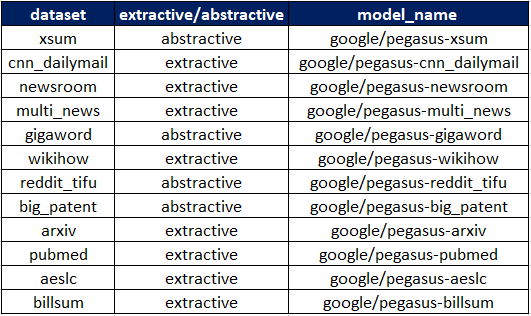
Source: https://pub.towardsai.net/summarization-using-pegasus-model-with-the-transformers-library-553cd0dc5c2

### Step 3.2 - Instatiate the metric of interest 

In [20]:
#instantiate rouge score
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

### Step 3.3 - Compute the summaries and evaluate

In [ ]:
#INFERENCE

## Sample with no fine-tunning 

import time

# create empry lists to store rouge scores
r1_precision = []
r2_precision = []
rL_precision = []

r1_recall = []
r2_recall = []
rL_recall = []

r1_fmeasure = []
r2_fmeasure = []
rL_fmeasure = []

val_model_output = []

# start counting seconds to keep track of time 
start = time.time()

# loop over validation set
for sample_id in range(len(val_input)):
    
    # get input (body OR abstract + cited text spans) - scisummnet uses abstract, we want to use body
    sample_input = val_input[sample_id]
    
    # tokenize it
    inputs = tokenizer([sample_input], max_length=1024, return_tensors='pt', truncation=True, padding=True)

    # 'max_length': Pad to a maximum length specified with the argument max_length 
    # or to the maximum acceptable input length for the model if that argument is not provided.

    # generate Summary
    summary_ids = model.generate(inputs['input_ids'])
    
    # decode summary
    sample_output = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids]
    
    # store summary
    val_model_output = val_model_output + sample_output
    
    # get reference (gold) summary 
    sample_reference = val_output[sample_id]
    
    #calculate rouge score
    scores = scorer.score(str(sample_reference), str(sample_output))
    
    r1_precision.append(scores['rouge1'][0])
    r1_recall.append(scores['rouge1'][1])
    r1_fmeasure.append(scores['rouge1'][2])
    
    r2_precision.append(scores['rouge2'][0])
    r2_recall.append(scores['rouge2'][1])
    r2_fmeasure.append(scores['rouge2'][2])
    
    rL_precision.append(scores['rougeL'][0])
    rL_recall.append(scores['rougeL'][1])
    rL_fmeasure.append(scores['rougeL'][2])
    
    if sample_id % 5 == 0:
        print(sample_id, time.time() - start)
        start = time.time()
    

0 32.089011907577515
5 154.72424602508545
10 247.23304510116577
15 181.95827889442444
20 282.8203761577606
25 221.4812240600586


### Step 3.4 - Evaluate

In [ ]:
# compute score statistics

all_socores = {'R1': [stats.mean(r1_precision), stats.mean(r1_recall), stats.mean(r1_fmeasure)],
        'R2': [stats.mean(r2_precision), stats.mean(r2_recall), stats.mean(r2_fmeasure)],
        'RL': [stats.mean(rL_precision), stats.mean(rL_recall), stats.mean(rL_fmeasure)]      
        }

all_socores_df = pd.DataFrame(all_socores, columns = ['R1', 'R2', 'RL'], index=['precision','recall','fmeasure'])

print(all_socores_df)   

In [ ]:
# visually check quality of cited text spans
# pick any number up to the total number of papers in the validation set
paper_id = 30 

print(val_input[paper_id])
print('------')
list(val_model_output[paper_id])

## Step 4 - Fine-Tune Pre-Trained Pegasus

In this step we will do the following:
 
Step 4.1 - Instantiate the model (the same as in step 3, so I'll skip it) \
Step 4.2 - Define metrics of interest \
Step 4.3 - Tokenize text data and wrap it into a torch Dataset \
Step 4.4 - Train and evaluate the model \
Step 4.5 - Save the model \
Step 4.6 - Instantiate the fine-tuned model \
Step 4.7 - Compute the summaries and evaluate \

Helpful resources: \
https://towardsdatascience.com/how-to-perform-abstractive-summarization-with-pegasus-3dd74e48bafb \
https://github.com/huggingface/transformers/blob/master/examples/seq2seq/run_summarization.py \
https://www.thepythoncode.com/article/finetuning-bert-using-huggingface-transformers-python








### Step 4.1 - Instantiate the model

In [25]:
# the same as in step 3, so I'll skip it

### Step 4.2 - Define metrics of interest

In [ ]:
# Metric
from datasets import load_dataset, load_metric
metric = load_metric("rouge")

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # rougeLSum expects newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Ignore pad token for loss: Replace -100 in the labels as we can't decode them.
    #     if data_args.ignore_pad_token_for_loss:
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    # Extract a few results from ROUGE
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

### Step 4.3 - Tokenize text data and wrap it into a torch Dataset

Since we gonna use Trainer from Transformers library, it expects our dataset as a torch.utils.data.Dataset, so we made a simple class that implements __len__() method that returns number of samples, and __getitem__() method to return a data sample at a specific index.

In [ ]:
import torch

class PegasusDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels['input_ids'][idx])  # torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)


In [ ]:
def prepare_data(model_name, 
                 train_texts, train_labels, 
                 val_texts=None, val_labels=None, 
                 test_texts=None, test_labels=None):
  """
  Prepare input data for model fine-tuning
  """
  tokenizer = PegasusTokenizer.from_pretrained(model_name)

  prepare_val = False if val_texts is None or val_labels is None else True
  prepare_test = False if test_texts is None or test_labels is None else True

  def tokenize_data(texts, labels):
    encodings = tokenizer(texts, truncation=True, padding=True)
    decodings = tokenizer(labels,  truncation=True, padding=True)
    dataset_tokenized = PegasusDataset(encodings, decodings)
    return dataset_tokenized

  train_dataset = tokenize_data(train_texts, train_labels)
  val_dataset = tokenize_data(val_texts, val_labels) if prepare_val else None
  test_dataset = tokenize_data(test_texts, test_labels) if prepare_test else None

  return train_dataset, val_dataset, test_dataset


In [ ]:
# rename variables
train_texts, train_labels = train_input, train_output 
val_texts, val_labels = val_input, val_output 

# prepare data
train_dataset, val_dataset, _ = prepare_data(model_name, train_texts, train_labels, val_texts, val_labels)

### Step 4.4 - Train and evaluate the model

In [ ]:
from transformers import Trainer, TrainingArguments
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

tokenizer = PegasusTokenizer.from_pretrained(model_name)

torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = PegasusForConditionalGeneration.from_pretrained(model_name).to(torch_device)

# define Training Arguments

training_args = Seq2SeqTrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=16,   # batch size per device during training
    per_device_eval_batch_size=32,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    logging_steps=1  ,               # log & save weights each logging_steps
    eval_steps=1,                    # number of update steps before evaluation
    evaluation_strategy="steps",     # evaluate each `logging_steps`
    predict_with_generate = True     # whether to use generate to calculate generative metrics (ROUGE, BLEU). 

    
)

trainer = Seq2SeqTrainer(
    model=model,                     # the instantiated 🤗 Transformers model to be trained
    tokenizer = tokenizer,           # the instantiated 🤗 Transformers tokenizer to be trained  
    args=training_args,              # training arguments, defined above
    train_dataset=train_dataset,     # training dataset
    eval_dataset=val_dataset,        # evaluation dataset
    compute_metrics=compute_metrics  # pass metric function
)

trainer.train()

In [ ]:
# evaluate
trainer.evaluate()

### Step 4.5 - Save the model 

In [ ]:
model.save_pretrained('fine_tuned')
tokenizer.save_pretrained('fine_tuned')

### Step 4.6 - Instantiate the fine-tuned model

In [ ]:
# instantiate the new model

model = PegasusForConditionalGeneration.from_pretrained('fine_tuned')
# The PEGASUS Model with a language modeling head. Can be used for summarization. 
# This model inherits from PreTrainedModel. 

tokenizer = PegasusTokenizer.from_pretrained('fine_tuned')

### Step 4.7 - Compute the summaries and evaluate

In [ ]:
#INFERENCE

## With fine-tunning 

# create empry lists to store rouge scores
r1_precision = []
r2_precision = []
rL_precision = []

r1_recall = []
r2_recall = []
rL_recall = []

r1_fmeasure = []
r2_fmeasure = []
rL_fmeasure = []

val_model_output = []

# start counting seconds to keep track of time 
start = time.time()

# loop over validation set
for sample_id in range(len(val_input)):
    
    # get input (body OR abstract + cited text spans) - scisummnet uses abstract, we want to use body
    sample_input = val_input[sample_id]
    
    # tokenize it
    inputs = tokenizer([sample_input], max_length=1024, return_tensors='pt', truncation=True, padding=True)

    # 'max_length': Pad to a maximum length specified with the argument max_length 
    # or to the maximum acceptable input length for the model if that argument is not provided.

    # generate Summary
    summary_ids = model.generate(inputs['input_ids'])
    
    # decode summary
    sample_output = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids]
    
    # store summary
    val_model_output = val_model_output + sample_output
    
    # get reference (gold) summary 
    sample_reference = val_output[sample_id]
    
    #calculate rouge score
    scores = scorer.score(str(sample_reference), str(sample_output))
    
    r1_precision.append(scores['rouge1'][0])
    r1_recall.append(scores['rouge1'][1])
    r1_fmeasure.append(scores['rouge1'][2])
    
    r2_precision.append(scores['rouge2'][0])
    r2_recall.append(scores['rouge2'][1])
    r2_fmeasure.append(scores['rouge2'][2])
    
    rL_precision.append(scores['rougeL'][0])
    rL_recall.append(scores['rougeL'][1])
    rL_fmeasure.append(scores['rougeL'][2])
    
    if sample_id % 5 == 0:
        print(sample_id, time.time() - start)
        start = time.time()
    

In [ ]:
# compute score statistics

all_socores = {'R1': [stats.mean(r1_precision), stats.mean(r1_recall), stats.mean(r1_fmeasure)],
        'R2': [stats.mean(r2_precision), stats.mean(r2_recall), stats.mean(r2_fmeasure)],
        'RL': [stats.mean(rL_precision), stats.mean(rL_recall), stats.mean(rL_fmeasure)]      
        }

all_socores_df = pd.DataFrame(all_socores, columns = ['R1', 'R2', 'RL'], index=['precision','recall','fmeasure'])

print(all_socores_df)   

# Trash code

In [32]:
# from transformers import Trainer, TrainingArguments
# from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

# def prepare_fine_tuning(model_name, train_dataset, val_dataset=None, freeze_encoder=False, output_dir='./results'):
#   """
#   Prepare configurations and base model for fine-tuning
#   """
#   torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
#   model = PegasusForConditionalGeneration.from_pretrained(model_name).to(torch_device)

#   if freeze_encoder:
#     for param in model.model.encoder.parameters():
#       param.requires_grad = False

#   if val_dataset is not None:
#     training_args = TrainingArguments(
#       output_dir=output_dir,           # output directory
#       do_train=True,  
#       num_train_epochs=5,              # total number of training epochs
#       per_device_train_batch_size=16,  # batch size per device during training, can increase if memory allows
#       per_device_eval_batch_size=32,   # batch size for evaluation, can increase if memory allows
#       save_steps=1,                  # number of updates steps before checkpoint saves
#       save_total_limit=5,              # limit the total amount of checkpoints and deletes the older checkpoints
#       evaluation_strategy='steps',     # evaluation strategy to adopt during training
#       eval_steps=1,                  # number of update steps before evaluation
#       warmup_steps=500,                # number of warmup steps for learning rate scheduler
#       weight_decay=0.01,               # strength of weight decay
#       logging_dir='./logs',            # directory for storing logs
#       logging_steps=32,
#       gradient_accumulation_steps=1,  
# #     output_dir="./checkpoints",
# #     per_device_train_batch_size=1,
# #     do_train=True,
# #     # fp16=True,  # This has a known bug with t5
# #     gradient_accumulation_steps=1,
# #     logging_steps=1,
# #     save_steps=1,
# #     overwrite_output_dir=True,
# #     save_total_limit=10,
#     )


#     trainer = Trainer(
#       model=model,                         # the instantiated 🤗 Transformers model to be trained
#       args=training_args,                  # training arguments, defined above
#       train_dataset=train_dataset,         # training dataset
#       eval_dataset=val_dataset             # evaluation dataset
#     )

#   else:
#     training_args = TrainingArguments(
# #       output_dir=output_dir,           # output directory
# #       num_train_epochs=5,              # total number of training epochs
# #       per_device_train_batch_size=1,  # batch size per device during training, can increase if memory allows
# #       save_steps=16,                  # number of updates steps before checkpoint saves
# #       save_total_limit=5,              # limit the total amount of checkpoints and deletes the older checkpoints
# #       warmup_steps=500,                # number of warmup steps for learning rate scheduler
# #       weight_decay=0.01,               # strength of weight decay
# #       logging_dir='./logs',            # directory for storing logs
# #       logging_steps=16,
# #       gradient_accumulation_steps=16,  
#     output_dir="./checkpoints",
#     per_device_train_batch_size=1,
#     do_train=True,
#     # fp16=True,  # This has a known bug with t5
#     gradient_accumulation_steps=1,
#     logging_steps=1,
#     save_steps=1,
#     overwrite_output_dir=True,
#     save_total_limit=10,
#     )

#     trainer = Trainer(
#       model=model,                         # the instantiated 🤗 Transformers model to be trained
#       args=training_args,                  # training arguments, defined above
#       train_dataset=train_dataset,         # training dataset
#     )

#   return trainer


# # Train

# trainer = prepare_fine_tuning(model_name, train_dataset, val_dataset)
# trainer.train()

# ### Step 4.6 - Instantiate the fine-tuned model